In [1]:
import pickle
import datetime
from blockchain import blockexplorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dbFile = "simple_loop_process.dat"
timeFile = "times.txt"
timeDiffFile = "times_diff.txt"
actualTimeFile = "actual_times.txt"
blockchains = []
times = []
timeDiffs = []
actual_diffs = []
orphans = []
outliers = []

Reads data from the dbFile. This reads in blocks so we can manipulate them. The type of each block is simpleBlock from blockchain explorer.

In [3]:
def readData():
    with open(dbFile,"rb") as f:
        for _ in range(407908):
            try:
                blockchains.append(pickle.load(f))
            except:
                break

Writes the times to a file. Should only need to be done once, but whatever.

In [4]:
def writeTimes():
    with open(timeFile,"w") as f:
        for value in blockchains:
            f.write(str(value.time)+"\n")
            

Reads in the times from the timeFile.

In [5]:
def readTimes():
    global times
    times = [line.rstrip('\n') for line in open(timeFile)]

In [6]:
readData()

In [7]:
#check that we read in the blocks
len(blockchains)

401470

In [8]:
readTimes()

In [9]:
#check that we read in the times
len(times)

401470

This is a test block. Allows you to examine the timing and info about block. Ignore this as its lame

In [10]:
#print blockchains[0].time
#print blockchains[0].hash
#print blockchains[0].height
#print "########"
#print blockchains[1].time
#print blockchains[1].hash
#print blockchains[1].height
#print "########"
#print int(blockchains[0].time) - int(blockchains[1].time)
a = datetime.datetime.fromtimestamp(1460972535)
b = datetime.datetime.fromtimestamp(1460972545)
print type(a)
print b
#Mon, 18 Apr 2016 09:42:15 GMT
#Mon, 18 Apr 2016 09:42:25 GMT
#print type(blockchains[0].main_chain )
c =  a - b
print c.total_seconds()
print divmod(c.days * 86400 + c.seconds, 60)

<type 'datetime.datetime'>
2016-04-18 09:42:25
-10.0
(-1, 50)


Function that iterates over the times list and computes the difference between two times next to each other. Writes out to time_diff.txt. Reports the block height, time, and whether in main chain for each block as well as the time between each block. The last digit is seconds between blocks. Sample:
```
407864(1460995794,True) - 407863(1460992454,True)==> 0:55:40 ==>3340.0
```

In [11]:
def processTimes():
    global times
    global timeDiffs
    counter = 0
    f = open(timeDiffFile,"w")
    for i in range(len(times)):
        if i == len(times)-1:
            break
        #value = int(times[i]) - int(times[i+1])
        value = datetime.datetime.fromtimestamp(int(blockchains[i].time)) - datetime.datetime.fromtimestamp(int(blockchains[i+1].time))
        
        timeDiffs.append(value.total_seconds())
        f.write(str(counter)+": "+str(blockchains[i].height)+"("+str(blockchains[i].time)+","+str(blockchains[i].main_chain)+","+datetime.datetime.fromtimestamp(int(blockchains[i].time)).strftime('%Y-%m-%d %H:%M:%S')+")"+" - "+str(blockchains[i+1].height)+"("+str(blockchains[i+1].time)+","+str(blockchains[i+1].main_chain)+","+datetime.datetime.fromtimestamp(int(blockchains[i+1].time)).strftime('%Y-%m-%d %H:%M:%S')+")"+"==> "+str(value)+" ==>"+str(value.total_seconds())+"\n")
        counter += 1
    f.close()

In [12]:
processTimes()

In [13]:
#test that we have the right data
len(timeDiffs)

401469

In [14]:
timeDiffs[0]

1566.0

Function that converts unix time to human readable times and writes them to a file. Ignore this

In [15]:
def convertTimes():
    global times
    global actual_diffs
    f = open(actualTimeFile,"w")
    for value in times:
        value = datetime.datetime.fromtimestamp(int(value)).strftime('%Y-%m-%d %H:%M:%S')
        f.write(value+"\n")
    for value in timeDiffs:
        value2 = datetime.datetime.fromtimestamp(int(value)).strftime('%Y-%m-%d %H:%M:%S')
        actual_diffs.append(value2)
    f.close()

This converts the data that is negative to positive values

In [16]:
timeDiff_data = []
for value in timeDiffs:
    if value < 0:
        timeDiff_data.append(-1*value)
    else:
        timeDiff_data.append(value)

In [17]:
#import matplotlib.pyplot as plt
def plot_data(seq):
    #plt.plot([1,2,3,4])
    plt.plot(timeDiff_data, seq)
    plt.ylabel('Time between blocks')
    plt.xlabel('Sequence')
    plt.show()

In [18]:
seq = []
for i in range(1,len(timeDiffs)+1):
    seq.append(i)

In [19]:
#plot_data(seq)
timeDiff_data[0]

1566.0

In [20]:
print len(timeDiff_data)
print len(seq)

401469
401469


In [21]:
def convertToMin(arr):
    temp = []
    for i in range(len(arr)):
        temp.append(arr[i]/60)
    return temp

In [48]:
del seq[-1]
del timeDiff_data[-1]

In [79]:
#df = pd.DataFrame({'index':seq,'time':convertToMin(timeDiff_data)})

df = pd.DataFrame({'index':seq[0:50],'time':timeDiff_data[0:50]})
#df = pd.DataFrame({'index':seq[0:50],'time':convertToMin(timeDiff_data[0:50])})
#df = pd.DataFrame({'index':seq[300:400],'time':convertToMin(timeDiff_data[300:400])})
#df = pd.DataFrame({'index':seq[300:400],'time':timeDiff_data[300:400]})
print df.describe()

          index         time
count  50.00000    50.000000
mean   25.50000   685.400000
std    14.57738   675.653637
min     1.00000    18.000000
25%    13.25000   252.750000
50%    25.50000   500.500000
75%    37.75000   878.000000
max    50.00000  3340.000000


In [46]:
#my_plot = df.plot(kind='bar')
timeDiff_mins = convertToMin(timeDiff_data)
temp = convertToMin(timeDiff_data[0:50])
print temp[6]

13.2666666667


In [74]:
print df.tail()

             time
401461   6.233333
401462   8.933333
401463  11.216667
401464   6.800000
401465   8.800000


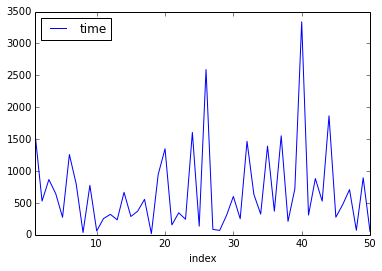

In [80]:
df.plot(kind='line',x='index',y='time')

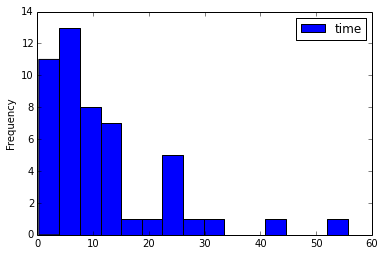

In [54]:
df2 = pd.DataFrame({'time':convertToMin(timeDiff_data[0:50])})
df2.plot(kind='hist',bins=15)

In [55]:
df2.describe()


,time
count,50.000000
mean,11.423333
std,11.260894
min,0.300000
25%,4.212500
50%,8.341667
75%,14.633333
max,55.666667


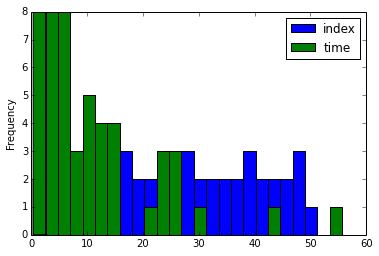

In [56]:
df.plot(kind='hist',bins=25)

In [29]:
def outlier(points,thresh=10):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [57]:
df3 = pd.DataFrame({'index':seq,'time':timeDiff_data})

x = outlier(df3['time'])
len(x)

401466

In [58]:
def remove_outliers(df):
    temp = []
    x = outlier(df)
    for i in range(len(df)):
        if x[i] == True:
            print "Removing ",df[i]
        else:
            temp.append(df[i])
    return temp

In [59]:
new  = remove_outliers(df3['time'])

Removing  89423.0
Removing  171553.0
Removing  170400.0
Removing  171798.0
Removing  172430.0
Removing  170936.0
Removing  171376.0
Removing  172335.0
Removing  172423.0
Removing  169865.0
Removing  171641.0
Removing  170977.0
Removing  172029.0
Removing  171688.0
Removing  171276.0
Removing  4699.0
Removing  172527.0
Removing  172161.0
Removing  172018.0
Removing  169839.0
Removing  171848.0
Removing  172451.0
Removing  172459.0
Removing  170650.0
Removing  169608.0
Removing  171137.0
Removing  172307.0
Removing  172274.0
Removing  172610.0
Removing  171256.0
Removing  171541.0
Removing  171705.0
Removing  172120.0
Removing  171980.0
Removing  171826.0
Removing  172695.0
Removing  171831.0
Removing  5018.0
Removing  171474.0
Removing  171010.0
Removing  171463.0
Removing  170807.0
Removing  172389.0
Removing  171947.0
Removing  170282.0
Removing  5426.0
Removing  172224.0
Removing  171820.0
Removing  171527.0
Removing  170460.0
Removing  171951.0
Removing  172109.0
Removing  169852.0


In [60]:
df4 = pd.DataFrame({'time':new})

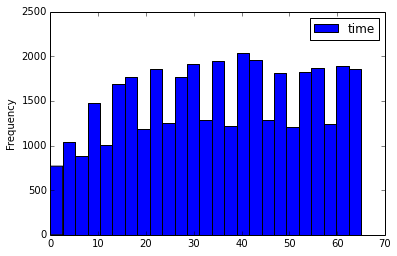

In [61]:
x = df4.plot(kind='hist',bins=25,range=[0, 65])

In [62]:
df4.describe()

,time
count,398357.000000
mean,574.343780
std,560.391405
min,0.000000
25%,173.000000
50%,405.000000
75%,796.000000
max,4546.000000


In [63]:
df4.head()

,time
0,1566.0
1,529.0
2,866.0
3,646.0
4,275.0


In [64]:
bins = np.linspace(min(df4['time']),max(df4['time']),25)

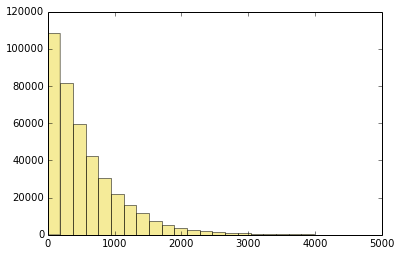

In [65]:
fig, ax = plt.subplots(1,1)
ax.hist(df4['time'],bins=bins,alpha=0.5,color='#EDD834')
#ax.set_xticks(bins[:-1])
plt.show()

In [66]:
def find_orphans():
    global orphans
    global blockchains
    orphans = []
    for i in blockchains:
        if i.main_chain == False:
            orphans.append(i)

In [67]:
len(orphans)

817

In [68]:
find_orphans()

In [69]:
len(orphans)

817

In [70]:
print orphans[0].time
print orphans[0].hash
print orphans[0].height

1460907019
00000000000000000307fce1866969b24cb465f98bf61519fbcc1f0dc05b0d80
407722


In [71]:
len(outliers)

0